![alternatvie text](https://www.doc.zuv.fau.de//M/FAU-Logo/01_FAU_Kernmarke/Web/FAU_Kernmarke_Q_RGB_blue.svg)

# Perception in Robotics

Summer Semester 2024, Friedrich-Alexander-Universität Erlangen-Nürnberg

# 4. Exercise - Features

In this exercise, we will work with the [car racing](https://www.gymlibrary.dev/environments/box2d/car_racing/) environment from [Gym](https://www.gymlibrary.dev/index.html). Our goal is to apply different computer vision approaches to the simulator.

The goal of this exercise is to implement the Harris Corner Detector and compare the Laplacian of Gaussian (LoG) with the Difference of Gaussian (DoG) for texture extraction on the generated data. For this purpose, the generated images from task A shall be used. 

The solutions for the assignment may be a Python Notebook or .py files. The visual results can be integrated into the notebook or a PDF document.

## A. Car Racing Simulation

In this exercise, a car drives on a track in a racing environment. The car can turn left, right, accelerate or decelerate. The output of the simulation is an image with 96x96 pixels.

The task of this exercise is to make use of the demo code in [car_racing.py](https://github.com/openai/gym/blob/master/gym/envs/box2d/car_racing.py) for driving the race car and produce images on which we will apply the Harris corner detector and LoG/DoG.

*Important*: You need to install [Gym](https://www.gymlibrary.dev/) in your system. The installation shall be done with [conda](https://conda.io/projects/conda/en/latest/user-guide/getting-started.html). It is highly recommended to install with anaconda on python <=3.11 using the following command: `  conda install conda-forge::gymnasium-box2d `. More information at [https://gym.openai.com/docs/#installation](https://github.com/openai/gym?tab=readme-ov-file#installation).

The simulation startes with a zoom in on the car, these corresponding images/frames shall be skipped before saving the images. Furthermore, you shall remove the black bar at the bottom of the images.

*Task Output*: Visualize 3 images from different driving situations (i.e., going straight and turning), which you save as a ".png" file.

In [1]:
import numpy as np
def convolve2d(image, kernel):
    """
    Apply a convolution kernel to a 2D image array.

    Parameters:
    image (np.array): 2D array of the image to be convolved.
    kernel (np.array): 2D array of the kernel to be used for convolution.

    Returns:
    out (np.array): 2D array of the convolved image.
    """
    padding=1
    stride=1
    kernel = np.flipud(np.fliplr(kernel))   #Cross Correlation to the kernel
    x_kernel, y_kernel=kernel.shape[0],kernel.shape[1]
    x_image,y_image=image.shape[0],image.shape[1]
    #print(x_image,y_image,x_kernel,y_kernel)
    x_output=int((((x_image+2*padding-x_kernel)/stride)+1))
    y_output=int((((y_image+2*padding-y_kernel)/stride)+1))
    output_image=np.zeros((x_output,y_output))
    padded_image=np.zeros((image.shape[0]+2*padding,image.shape[1]+2*padding))
    padded_image[int(padding):-1,int(padding):-1]=image
    for y in range(image.shape[1]):
        if y>image.shape[1]-y_kernel:
            break
        if y%stride==0:
            for x in range(image.shape[0]):
                if x>image.shape[0]-x_kernel:
                    break
                try:
                    if x%stride==0:
                        output_image[x,y]=(kernel*padded_image[x:x+x_kernel,y:y+y_kernel]).sum()
                except:
                    break
    return output_image


## B. Harris Corner Detector

In this exercise, the Harris corner detector should be implemented for the Car Racing images. It should be programmed from scratch using **numpy**, while the gradients can be extracted using the Sobel operator of **OpenCV**. The implementation of the Harris corner detection from **OpenCV** can be used for verifying the results. Visualize the detected corners and edges.

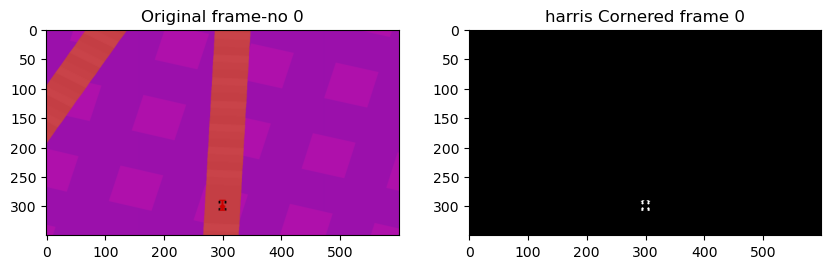

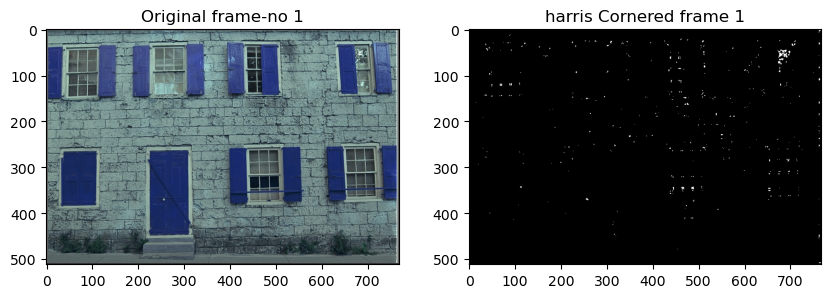

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import gymnasium as gym
from matplotlib.backends.backend_pdf import PdfPages
from scipy.ndimage import maximum_filter

#Function used for Capturing frames
# def capture_frames(env,actions, num_frames=3,steps_per_action=10, skip_initial_frames=20):
#     frames = []
#     observation, info = env.reset()
#     for _ in range(skip_initial_frames):
#         action = env.action_space.sample()
#         observation, reward, terminated, truncated, info = env.step(action)
#         if terminated or truncated:
#             observation, info = env.reset()
    
#     for action in actions:
#         for _ in range(steps_per_action):
#             observation, reward, terminated, truncated, info = env.step(action)
#             frame = env.render()  # Capture the frame
#             frames.append(frame)
#             if terminated or truncated:
#                 observation, info = env.reset()

#     return frames
def gaussian_kernel(size, sigma):
    """Generate a Gaussian kernel."""
    k = size // 2
    x, y = np.mgrid[-k:k+1, -k:k+1]
    g = np.exp(-(x**2 + y**2) / (2 * sigma**2))
    return g / g.sum()

def remove_black_bar(frame):
    height, width, _ = frame.shape
    cropped_frame = frame[:height-50, :, :]  # Crop the bottom black bar
    return cropped_frame


def harris_corner_detection(image,k=0.05,block_size=3,ksize=3,threshold=0.05):
    #Convert to gray scale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    new_image=image
    corner_list=[]
    # Compute gradients using Sobel filter
    Ix = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=ksize)
    Iy = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=ksize)
    Ix2 = Ix * Ix
    Iy2 = Iy * Iy
    Ixy = Ix * Iy

    #Use Gaussian Blur with sigma=1
    gaussian=gaussian_kernel(block_size,sigma=1)
    #Sx2 = cv2.GaussianBlur(Ix2, (block_size,block_size), 1)
    #Sy2 = cv2.GaussianBlur(Iy2, (block_size,block_size), 1)
    #Sxy = cv2.GaussianBlur(Ixy, (block_size,block_size), 1)
    Sx2=convolve2d(Ix2,gaussian)
    Sy2=convolve2d(Iy2,gaussian)
    Sxy=convolve2d(Ixy,gaussian)
    # Harris corner response
    detH = (Sx2 * Sy2) -(Sxy**2)
    traceH = Sx2 + Sy2
    R = detH - k * (traceH ** 2)
    corners = np.zeros_like(R)
    corners[R > threshold * R.max()] = 255
    #Non-maximum Supression
    # for y in range(R.shape[0]):
    #     for x in range(R.shape[1]):
    #         r = R[y, x]
    #         if r > threshold*R.max():
    #             corner_list.append([x, y, r])
    #             new_image[y, x] = (0, 0,0)
    return corners
def non_maximum_suppression(R, threshold):
    # Apply a maximum filter to find local maxima
    local_max = maximum_filter(R, size=3)
    
    # Only keep the points that are equal to local max and greater than threshold
    R_nms = np.where((R == local_max) & (R > threshold), R, 0)
    
    return R_nms

def main():
    env = gym.make("CarRacing-v2",render_mode="rgb_array", domain_randomize=True)
    frame1=cv2.imread("./Frame0.png")
    frame2=cv2.imread("./IMAGES/kodim01.png")
    # frame3=cv2.imread("Frame12.png")
    # frame4=cv2.imread("Frame18.png")
    # frame5=cv2.imread("Frame24.png")
    frames=[frame1,frame2]
    #frames=[remove_black_bar(frame) for frame in frames]
    for i in range(0,len(frames)):
        plt.figure(figsize=(10, 5))
        plt.subplot(121)
        plt.imshow(frames[i])
        plt.title(f"Original frame-no {i}")
        Corner_image=harris_corner_detection(frames[i])
        # threshold = 0.01 * Corner_image.max()

        # Apply non-maximum suppression to R
       # R_nms = non_maximum_suppression(Corner_image, threshold)
        # conr_cv=cv2.cornerHarris(np.float32(frames[i]),3,3,0.05)
        # conr_cv = cv2.dilate(conr_cv, None)
        # frames[i][conr_cv > 0.01 * conr_cv.max()]=[0, 0, 255]
        plt.subplot(122)
        plt.imshow(Corner_image,cmap='gray')
        plt.title(f"harris Cornered frame {i}")
        # plt.subplot(132)
        # plt.imshow(frames[i])
        # plt.title(f"Corner cv {i}")
        # plt.show()
    env.close()
if __name__=="__main__":
    main()


## C. Laplacian of Gaussian

In this exercise, the Laplacian of Gaussian (LoG) and the Difference of Gaussians (DoG) should be implemented. Similarly to task B, it is fine to use **OpenCV** functions for the gradient computation. Visualize the detected features and compare the results of Laplacian of Gaussian with the differences of Gaussian.

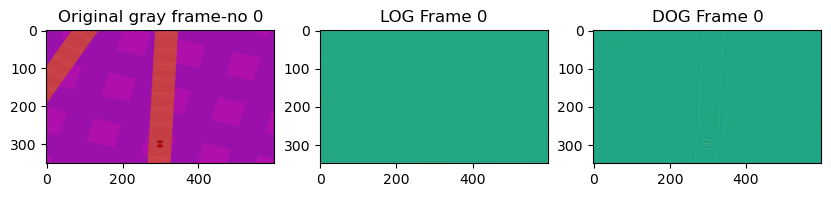

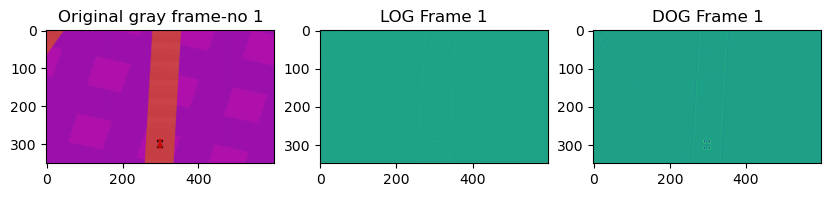

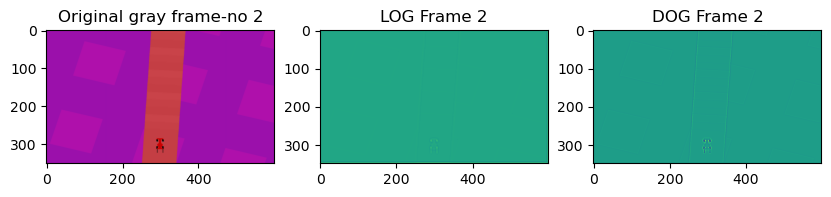

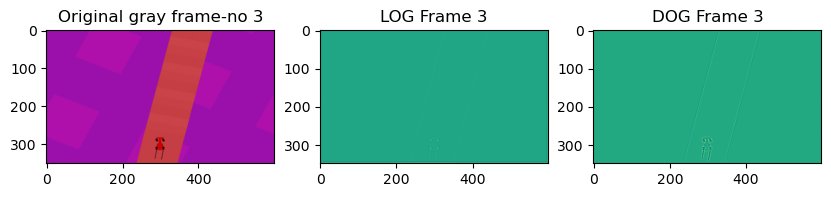

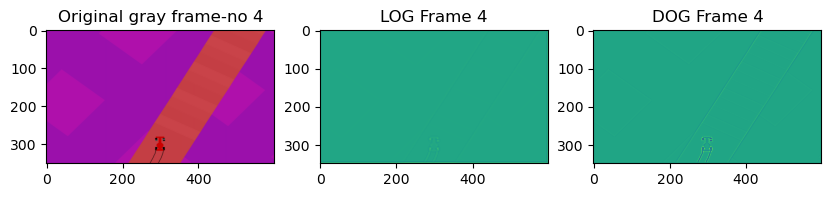

In [5]:
def laplacian_of_gaussian(image,kernel_size=5,sigma=5):
    gaussian=gaussian_kernel(kernel_size,sigma)
    gaussian_blurred_image=convolve2d(image,gaussian)
    #laplacian_kernel = np.array([[0, 1, 0],
    #                              [1, -4, 1],
    #                              [0, 1, 0]])
    log_image=cv2.Laplacian(gaussian_blurred_image,cv2.CV_64F)
    #log_image = convolve2d(gaussian_blurred_image, laplacian_kernel)
    return log_image
def difference_of_gaussian(image,kernel_size=5,sigma1=1/np.sqrt(2),sigma2=np.sqrt(2)):
    gaussian1=gaussian_kernel(kernel_size,sigma1)
    gaussian2=gaussian_kernel(kernel_size,sigma2)
    blurred1=convolve2d(image,gaussian1)
    blurred2=convolve2d(image,gaussian2)
    dog_image=blurred1-blurred2
    return dog_image
def main():
    frame1=cv2.imread("./Frame0.png")
    frame2=cv2.imread("Frame6.png")
    frame3=cv2.imread("Frame12.png")
    frame4=cv2.imread("Frame18.png")
    frame5=cv2.imread("Frame24.png")
    frames=[frame1,frame2,frame3,frame4,frame5]
    frames1=[cv2.cvtColor(frame,cv2.COLOR_RGB2GRAY) for frame in frames]
    for i in range(0,len(frames)):
        plt.figure(figsize=(10, 5))
        plt.subplot(131)
        plt.imshow(frames[i])
        plt.title(f"Original gray frame-no {i}")
        log_image=laplacian_of_gaussian(frames1[i])
        plt.subplot(132)
        plt.imshow(log_image)
        plt.title(f"LOG Frame {i}")
        dog_image=difference_of_gaussian(frames1[i])
        plt.subplot(133)
        plt.imshow(dog_image)
        plt.title(f"DOG Frame {i}")
        plt.show()
if __name__=="__main__":
    main()